In [1]:
import sys
sys.path.insert(0, '../')
from gw_tools.gw_plot import gw_plot
from gw_tools import data_prep
from gw_tools.gw_cnn import gw_cnn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Getting started

After initial cleaning and preparation we:
1. Select the columns we'll be using to train our model:
    - Target:
        - `avg_well_depth`
    - Features:
        - `date`
        - `gage_ht`
        - `discharge_cfs`
        - `prcp`
        - `temp_avg`
        - `hum_avg`
        - `hPa_avg`
        - `wind_avg`
        - `gust_avg`
        - `prcp_lag_45D`
2. Replace the `date` column with two time of year signal columns `year_sin` and `year_cos` that are constructed by expressing each data as a UNIX epoch (number of seconds since Januray 1, 1970), and computing
$$\text{year\_sin}(t)=\sin\left(\frac{2\pi t}{31556952}\right) \hspace{2cm} \text{year\_cos}(t)=\cos\left(\frac{2\pi t}{31556952}\right)$$
where $365.2425\cdot 24 \cdot 60 \cdot 60=31556952$ is the number of seconds in a year.
3. Set aside a holdout set for eveluating the perfomance of our final models. 

In [2]:
## Load cleaned data
df = data_prep.load_data('APK309')
## Select features for training
df = data_prep.select_features(df)
## Add time of year signal information
df = data_prep.add_toy_signal(df)
## Set aside holdout data for final model validation
X_train, X_holdout, y_train, y_holdout, dt_train, dt_holdout = data_prep.prep_data_for_training(df)

# Baseline Models

We will use two models for comparision to the neural networks models that we consrtuct later.

## Training mean
Predictions for future values will be the mean of the training data.

On the holdout set, the root mean squared error for the "predict the mean" model is 3.205924753505327.


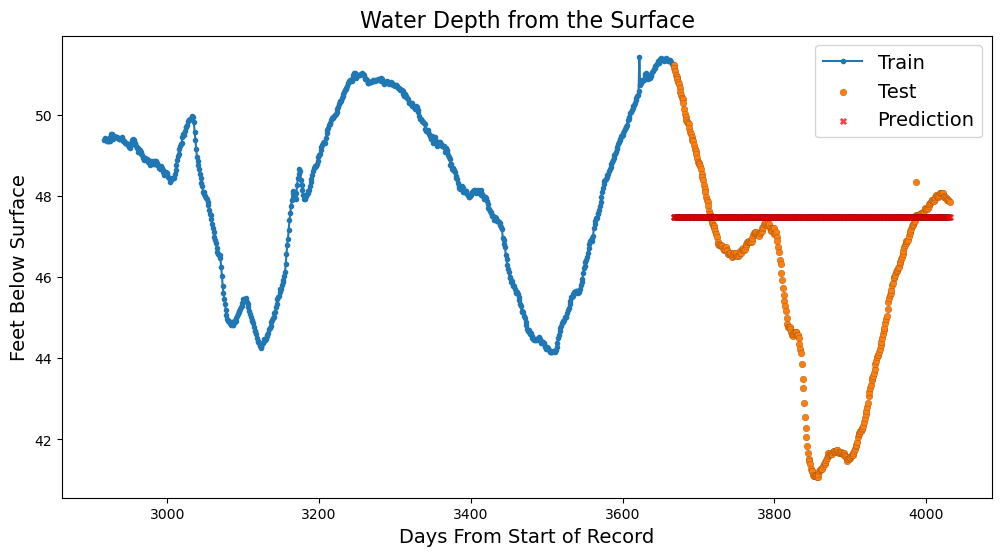

In [3]:
## Predict the Average Model
pred_avg = np.ones(len(y_holdout))*y_train.mean()
## Score the model
score_avg = mean_squared_error(y_holdout, pred_avg)
print(f'On the holdout set, the root mean squared error for the "predict the mean" model is {np.sqrt(score_avg)}.')
gw_plot(train=y_train, test=y_holdout, pred=pred_avg, train_limit=750)

## Linear Regression
Prediction for the future will be based on a linear regression model fit to the training data.

On the holdout set, the root mean squared error for this linear regression model is 1.7315118027857022.


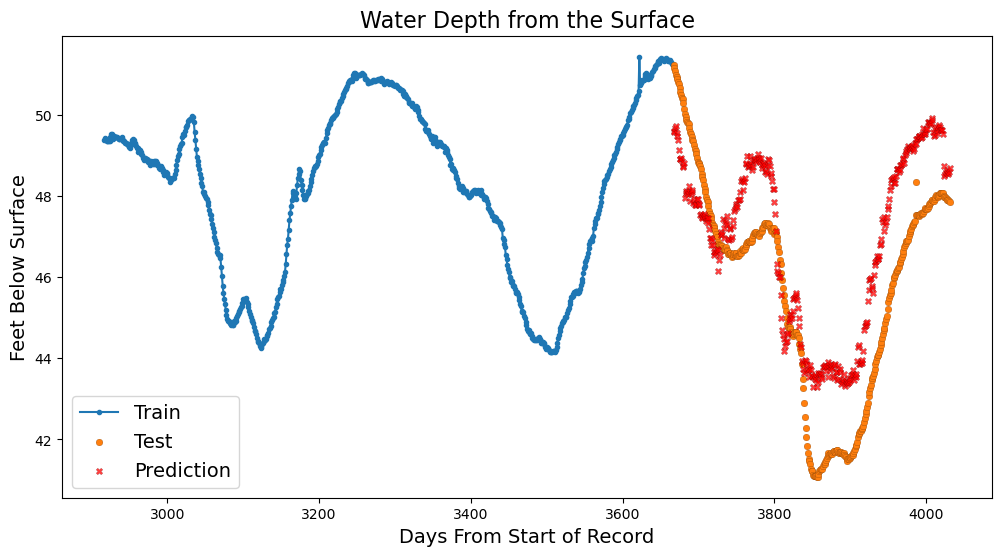

1.1469083770826634

In [4]:
## Linear Regression Model
## Create an instance of the LinearRegression class
linear = LinearRegression(copy_X=True)
## Fit the model to the training data
linear.fit(X_train, y_train)
## Make predictions on the test data
pred_lin = linear.predict(X_holdout)
score_lin = mean_squared_error(y_holdout, pred_lin)
print(f'On the holdout set, the root mean squared error for this linear regression model is {np.sqrt(score_lin)}.')
gw_plot(train=y_train, test=y_holdout, pred=pred_lin, train_limit=750)
np.sqrt(np.mean(y_holdout-pred_lin)**2)